# PPE analysis template
- Daniel Kennedy (djk2120@ucar.edu)
- updated January 23, 2022
- note that there are dependencies to other files in the repo

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

In [3]:
### import some analysis functions we wrote for this project
###  note that you can inspect the code for these functions in ../ppe_tools/analysis.py
import sys ; sys.path.append("..")
from ppe_tools.analysis import *

### optional: set up your PBSCluster
- not necessary if you are working with preprocessed data
- client.cluster will show when your workers are active
- note it can take a few minutes to get through the job queue
- set up to ask for 1hr, but can be increased

In [4]:
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [5]:
## wait until workers >0
client.cluster

In [13]:
topdir = '/glade/scratch/djk2120/PPEn11/hist/amflx/'
files  = [glob.glob(topdir+'*'+str(i).zfill(4)+'*')[0] for i in np.arange(201)]


In [14]:
ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True)

In [15]:
ix = np.arange(len(ds.time))>0

In [56]:
gpp=ds.FPSN.isel(time=ix).mean(dim='time').compute()
sw =ds.SOILWATER_10CM.isel(time=ix).mean(dim='time').compute()

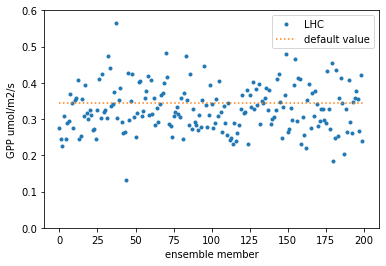

In [22]:
plt.plot(gpp[1:],'.',label='LHC')
x=[0,200]
y=[gpp[0],gpp[0]]
plt.plot(x,y,':',label='default value')
plt.ylim([0,0.6])
plt.xlabel('ensemble member')
plt.ylabel('GPP umol/m2/s')
plt.legend();

In [40]:
lhckey = '/glade/scratch/djk2120/PPEn11/amflx_lhc/lhc_220224.txt'
df = pd.read_csv(lhckey)

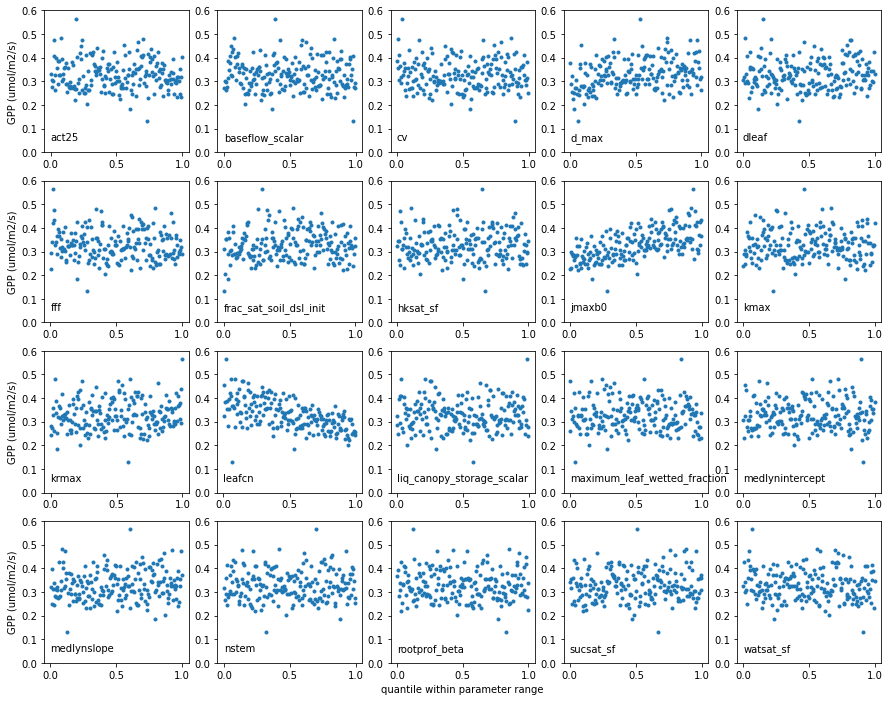

In [68]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(4,5,i+1)
    plt.plot(df[p],gpp[1:],'.')
    plt.ylim([0,0.6])
    plt.text(0,0.05,p)
    if i%5==0:
        plt.ylabel('GPP (umol/m2/s)')
    if i==17:
        plt.xlabel('quantile within parameter range')

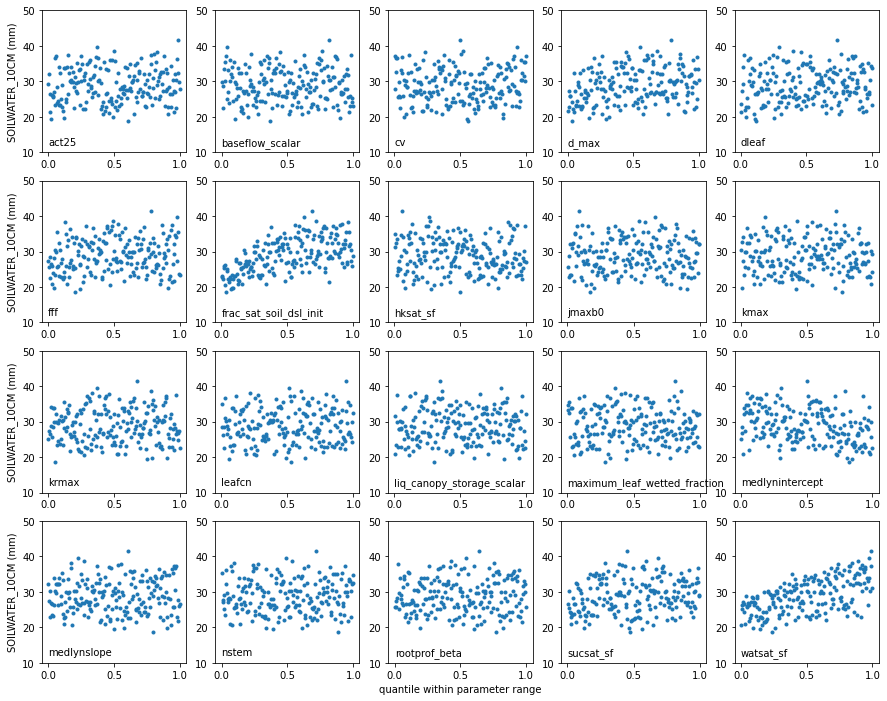

In [66]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(4,5,i+1)
    plt.plot(df[p],sw[1:],'.')
    plt.ylim([10,50])
    plt.text(0,12,p)
    if i%5==0:
        plt.ylabel('SOILWATER_10CM (mm)')
    if i==17:
        plt.xlabel('quantile within parameter range')